In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import roc_curve
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,  PolynomialFeatures   
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [2]:
data= pd.read_csv("C:\\Users\\HP\\Desktop\\data.csv")
# Split the inputs and outputs into separate arrays
# x = data[ :, 0]
# y = data[:,1]
#training_data = data[:70]
feature_cols=['location',	'country' ,	'gender' ,	'age' ,	'vis_wuhan',	'from_wuhan',	'symptom1'	,'symptom2'	,'symptom3'	,'symptom4'	,'symptom5'	,'symptom6', 	'diff_sym_hos'
]
x=data[feature_cols]
y=data.result
# Convert 1-D arrays into 2-D because the commands later will require it
# x = np.expand_dims(x, axis=1)
# y = np.expand_dims(y, axis=1)
# Get 70% of the dataset as the training set. Put the remaining 30% in temporary variables: x_test and y_test.
x_train, x_both, y_train, y_both = train_test_split(x, y, test_size=0.30, random_state=3)
# Split the 30% subset above into two: one half for cross validation and the other for the test set
x_cv, x_test, y_cv, y_test = train_test_split(x_both, y_both, test_size=0.50, random_state=3)
#another approach to divide data 
#train, validate, test = np.split(df.sample(frac=1, random_state=42), #60 training 20 validation 20 test 
                      # [int(.6*len(df)), int(.8*len(df))]) 


In [3]:
df = pd.DataFrame(x) 
print(df.head())

   location  country  gender   age  vis_wuhan  from_wuhan  symptom1  symptom2  \
0       104        8       1  66.0          1           0        14        31   
1       101        8       0  56.0          0           1        14        31   
2       137        8       1  46.0          0           1        14        31   
3       116        8       0  60.0          1           0        14        31   
4       116        8       1  58.0          0           0        14        31   

   symptom3  symptom4  symptom5  symptom6  diff_sym_hos  
0        19        12         3         1             8  
1        19        12         3         1             0  
2        19        12         3         1            13  
3        19        12         3         1             0  
4        19        12         3         1             0  


In [4]:
cor_matrix = df.corr()
print(cor_matrix)

              location   country    gender       age  vis_wuhan  from_wuhan  \
location      1.000000  0.309347  0.030077 -0.027330   0.022821    0.080120   
country       0.309347  1.000000  0.193208  0.072339  -0.149798   -0.194170   
gender        0.030077  0.193208  1.000000 -0.020662  -0.005588   -0.138997   
age          -0.027330  0.072339 -0.020662  1.000000  -0.157173   -0.051229   
vis_wuhan     0.022821 -0.149798 -0.005588 -0.157173   1.000000   -0.154200   
from_wuhan    0.080120 -0.194170 -0.138997 -0.051229  -0.154200    1.000000   
symptom1      0.033078 -0.078971  0.146706 -0.209028   0.087330    0.036539   
symptom2      0.017961 -0.085210  0.116159 -0.127251   0.094360    0.046923   
symptom3      0.010472 -0.042933  0.090858 -0.074863   0.086113    0.068144   
symptom4     -0.026823 -0.018526  0.021882 -0.069396   0.063738    0.021704   
symptom5      0.033692 -0.009371  0.026320  0.049817   0.025780    0.018999   
symptom6      0.015341 -0.004384  0.039867  0.055145

In [5]:
# upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
# print(upper_tri)

In [6]:
corr = data.corr()
corr.head()

,Unnamed: 0,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
Unnamed: 0,1.000000,-0.123488,0.311170,0.182616,0.069737,-0.293568,-0.223951,0.053031,0.061755,0.082368,0.038603,-0.017153,0.022695,-0.129907,0.046838
location,-0.123488,1.000000,0.309347,0.030077,-0.027330,0.022821,0.080120,0.033078,0.017961,0.010472,-0.026823,0.033692,0.015341,-0.119397,0.046240
country,0.311170,0.309347,1.000000,0.193208,0.072339,-0.149798,-0.194170,-0.078971,-0.085210,-0.042933,-0.018526,-0.009371,-0.004384,-0.146037,-0.094443
gender,0.182616,0.030077,0.193208,1.000000,-0.020662,-0.005588,-0.138997,0.146706,0.116159,0.090858,0.021882,0.026320,0.039867,-0.176528,-0.061441
age,0.069737,-0.027330,0.072339,-0.020662,1.000000,-0.157173,-0.051229,-0.209028,-0.127251,-0.074863,-0.069396,0.049817,0.055145,0.074573,0.515127


<AxesSubplot: >

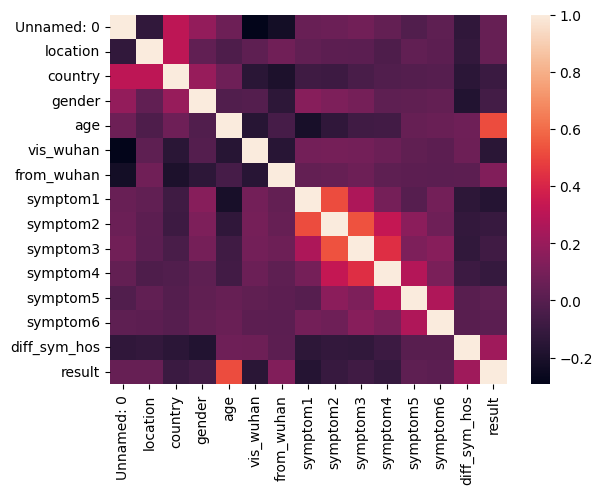

In [7]:
sns.heatmap(corr)


We will try to predict using the cross-validation dataset and calculate the accuracy between the expected output and the original output by random number of neighbors 

In [8]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_cv)
print(confusion_matrix(y_cv, y_pred))
print(classification_report(y_cv, y_pred))


[[112   4]
 [  7   6]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       116
           1       0.60      0.46      0.52        13

    accuracy                           0.91       129
   macro avg       0.77      0.71      0.74       129
weighted avg       0.91      0.91      0.91       129



True positive 114 out of 116
True negative are 7 out of 13

In [9]:
from sklearn import metrics 
print("Accuracy ",metrics.accuracy_score(y_cv,y_pred))
print("roc score",metrics.roc_auc_score(y_cv,y_pred))#row curve is the best method

Accuracy  0.9147286821705426
roc score 0.7135278514588861


try k manually

In [10]:
knn1 = KNeighborsClassifier(n_neighbors=3)
knn1.fit(x_train, y_train)
y_pred1 = knn1.predict(x_cv)
print(confusion_matrix(y_cv, y_pred1))
print(classification_report(y_cv, y_pred1))


[[115   1]
 [  8   5]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       116
           1       0.83      0.38      0.53        13

    accuracy                           0.93       129
   macro avg       0.88      0.69      0.74       129
weighted avg       0.92      0.93      0.92       129



In [11]:
from sklearn import metrics 
print("Accuracy ",metrics.accuracy_score(y_cv,y_pred1))
print("roc score",metrics.roc_auc_score(y_cv,y_pred1))#row curve is the best method

Accuracy  0.9302325581395349
roc score 0.6879973474801061


In [12]:
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(x_train, y_train)
y_pred5 = knn5.predict(x_cv)
print(classification_report(y_cv, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       116
           1       0.60      0.46      0.52        13

    accuracy                           0.91       129
   macro avg       0.77      0.71      0.74       129
weighted avg       0.91      0.91      0.91       129



In [13]:
from sklearn import metrics 
print("Accuracy ",metrics.accuracy_score(y_cv,y_pred5))
print("roc score",metrics.roc_auc_score(y_cv,y_pred5))#row curve is the best method

Accuracy  0.9302325581395349
roc score 0.7221485411140585


In [26]:
knn9 = KNeighborsClassifier(n_neighbors=9)
knn9.fit(x_train, y_train)
y_pred9 = knn9.predict(x_cv)
# print(classification_report(y_cv, y_pred9))
print("Accuracy ",metrics.accuracy_score(y_cv,y_pred9))
print("precision: ", metrics.precision_score(y_cv,y_pred9))


print("F1 Score: ", metrics.f1_score(y_cv,y_pred9))

print("Recall: ", metrics.recall_score(y_cv,y_pred9))

print("ROC Score: ", metrics.roc_auc_score(y_cv,y_pred9))

Accuracy  0.9147286821705426
precision:  0.625
F1 Score:  0.4761904761904762
Recall:  0.38461538461538464
ROC Score:  0.6793766578249337


In [15]:
knn7 = KNeighborsClassifier(n_neighbors=7)
knn7.fit(x_train, y_train)
y_pred7 = knn7.predict(x_cv)
# print(classification_report(y_cv, y_pred9))

print("precision: ", metrics.precision_score(y_cv,y_pred7))


print("F1 Score: ", metrics.f1_score(y_cv,y_pred7))

print("Recall: ", metrics.recall_score(y_cv,y_pred7))

print("ROC Score: ", metrics.roc_auc_score(y_cv,y_pred7))

precision:  0.75
F1 Score:  0.5714285714285714
Recall:  0.46153846153846156
ROC Score:  0.7221485411140585


In [16]:
from sklearn import metrics 
print("Accuracy ",metrics.accuracy_score(y_cv,y_pred9))
print("roc score",metrics.roc_auc_score(y_cv,y_pred9))#row curve is the best method

Accuracy  0.9147286821705426
roc score 0.6793766578249337


Find the optimal k by cross-validation scores by finding the highest score therefor will be the highest k


In [29]:
from sklearn.model_selection import cross_val_score
neighbors=[]
cv_scores=[]
for k in range(1, 21, 2):
    neighbors.append(k)
    knn2=KNeighborsClassifier ( n_neighbors=k)
    scores=cross_val_score(knn2,x_train,y_train,cv=15, scoring='roc_auc')
    cv_scores.append(scores.mean())

print(cv_scores)
    

[0.8550513538748833, 0.9220018674136322, 0.9277507002801122, 0.9421774042950514, 0.9481185807656395, 0.9428169934640523, 0.940717086834734, 0.9454565826330533, 0.9449626517273576, 0.944908496732026]


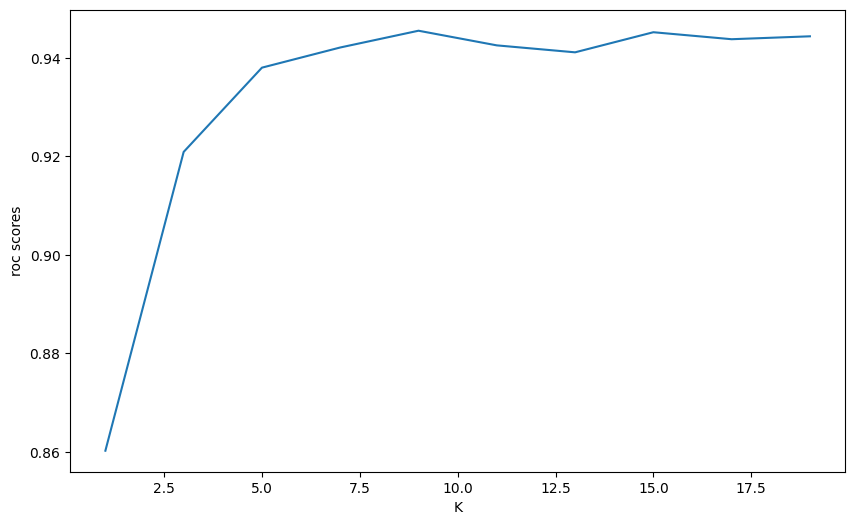

In [18]:
plt.figure(figsize=(10,6))
plt.plot(neighbors,cv_scores)
plt.xlabel("K")
plt.ylabel("roc scores")
plt.show()

In [19]:
# optimal_k=k_range[np.argmax(cv_scores)]
# print(f" The optimal number of neigbors is {optimal_k} ")


optimal k is  9


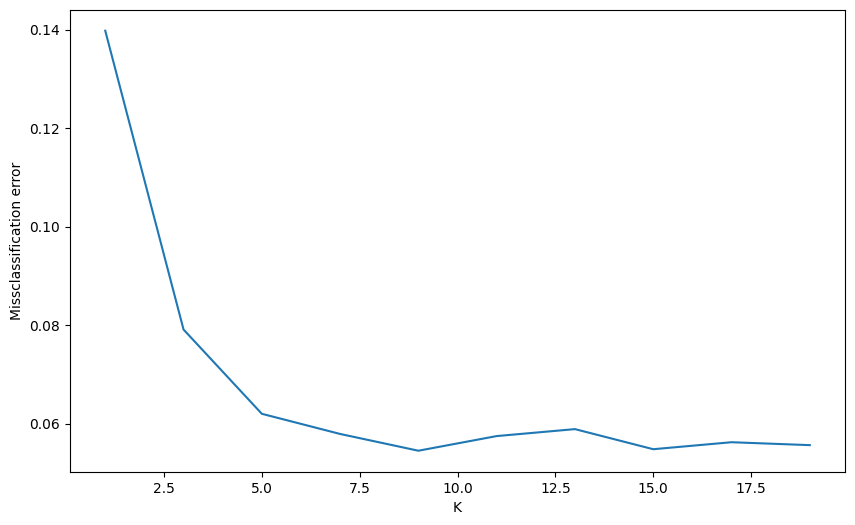

In [20]:

# for determining the best k
MSE=[1-x for x in cv_scores]
optimal_k =neighbors[MSE.index(min(MSE))]
print("optimal k is " ,optimal_k)
plt.figure(figsize=(10,6))
plt.plot(neighbors,MSE)
plt.xlabel("K")
plt.ylabel("Missclassification error")
plt.show()


In [46]:
knn3 = KNeighborsClassifier(n_neighbors=3, algorithm = 'auto')
knn3.fit(x_train, y_train)
y_pred = knn3.predict(x_cv)
print(confusion_matrix(y_cv, y_pred))
print(classification_report(y_cv, y_pred))

[[115   1]
 [  8   5]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       116
           1       0.83      0.38      0.53        13

    accuracy                           0.93       129
   macro avg       0.88      0.69      0.74       129
weighted avg       0.92      0.93      0.92       129



In [47]:
from sklearn import metrics 
print("Accuracy ",metrics.accuracy_score(y_cv,y_pred))
print("roc score",metrics.roc_auc_score(y_cv,y_pred))#row curve is the best method

Accuracy  0.9302325581395349
roc score 0.6879973474801061


In [22]:
#KNN
from sklearn.model_selection import GridSearchCV
rf_params = {
    'n_neighbors': [1,2,3,4,5,7,9,10,11,15,20],
    'metric':["minkowski","manhattan","euclidean"],
    'weights': ["distance","uniform"],
    
}
clf = KNeighborsClassifier()
grid = GridSearchCV(clf, rf_params, cv=10, scoring='accuracy')
# grid = GridSearchCV(clf, rf_params, cv=5, scoring='accuracy')
# grid = GridSearchCV(clf, rf_params, cv=3, scoring='accuracy')
grid.fit(x_train, y_train)
print(grid.best_params_)
print("Accuracy:"+ str(grid.best_score_))

{'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}
Accuracy:0.9520218579234973


In [23]:
pd.crosstab(y_cv, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,112,4,116
1,7,6,13
All,119,10,129


Tunning hyperparameter 'k' using GridSearch

In [24]:
def gridSearch(classifier, parameters, XTr, yTr, cv):
    print("***** Grid Search *****")
    print("Cross-Validation: ", cv)

    scores = ['accuracy']
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()
        if (score == 'accuracy'):
            scoring_method = score
        else:
            scoring_method = score + '_micro'

        clf = GridSearchCV(classifier,
                           param_grid=parameters,
                           cv=cv,
                           scoring=scoring_method)
        clf.fit(XTr, yTr)

        print("Best parameters and scores set found on development set:")
        # print(self.clf.best_estimator_)
        print(clf.best_params_)
        print(clf.best_score_)
        print()

        return clf.best_params_

In [25]:


def tuneParameterWithKNN(XTr, yTr):
    classifier = KNeighborsClassifier()
    parameters = {
        'n_neighbors': [1,2, 3, 5, 7,9,11,13,15],
        'weights': ["distance","uniform"],
        'algorithm': ["auto", "kd_tree", "ball_tree"],
        'metric':["minkowski","manhattan","euclidean"],
        'leaf_size': [20, 30, 40, 50]
        # 'n_jobs': [-1]
    }
    best_params = gridSearch(classifier, parameters, XTr, yTr, 5)

    print("*** Classification ***")
    clf = KNeighborsClassifier()
    clf.set_params(**best_params)
    print("Test Result for KNN Classifier")
    acc = cross_val_score(clf, XTr, yTr, cv=5)
    print (acc)
    print("Accuracy: %0.2f (+/- %0.2f)" % (acc.mean(), acc.std() * 2))
   
tuneParameterWithKNN(x_train,y_train)    

***** Grid Search *****
Cross-Validation:  5
# Tuning hyper-parameters for accuracy

Best parameters and scores set found on development set:
{'algorithm': 'auto', 'leaf_size': 40, 'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
0.9503719008264463

*** Classification ***
Test Result for KNN Classifier
[0.9338843  0.94214876 0.94214876 0.95867769 0.975     ]
Accuracy: 0.95 (+/- 0.03)
